# French web domain classification
## An analysis on the data
**Team: Samuel - TuAnh - HaiYen**

This is the notebook containing our studies of the datasets.

This is a kaggle notebook.

## Importation of the data and the packages

In [1]:
import os, codecs
from os import path
import re

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


from nltk.corpus import stopwords 
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn import preprocessing

import csv

import networkx as nx


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Sequential
from keras.initializers import Constant

from keras.layers import Bidirectional 
from keras.preprocessing import text

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Bidirectional, LSTM, Dense, Activation, Dropout

import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Read training data
path_data = "/kaggle/input/fr-domain-classification/"

with open(path_data+"train.csv", 'r') as f:
    train_data = f.read().splitlines()

train_hosts = list()
y_train = list()
for row in train_data:
    host, label = row.split(",")
    train_hosts.append(host)
    y_train.append(label.lower())

# Read test data
with open(path_data+"test.csv", 'r') as f:
    test_hosts = f.read().splitlines()

label_array = np.array(['business/finance', 'education/research', 'entertainment',
       'health/medical', 'news/press', 'politics/government/law',
       'sports', 'tech/science'])

In [3]:
# Load the textual content of a set of webpages for each host into the dictionary "text". 
# The encoding parameter is required since the majority of our text is french.
text = dict()
filenames = os.listdir(path_data+'text/text')
for filename in filenames:
    with codecs.open(path.join(path_data+'text/text/', filename), encoding='utf8',errors='ignore') as f: 
        text[filename] = f.read().replace("\n", "").lower()

## Analysis of the distribution of the labels

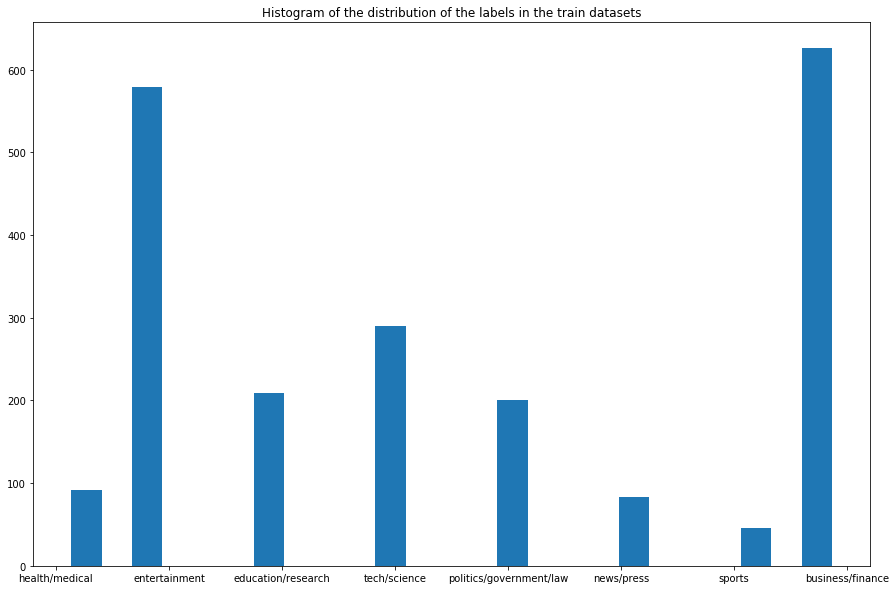

In [4]:
plt.rcParams["figure.figsize"] = (15,10)
plt.hist(y_train, align='mid',rwidth =0.5,bins='auto')
plt.title("Histogram of the distribution of the labels in the train datasets")
plt.show()

## Preprocessing of the data

In [5]:
stop_words_fr = set(stopwords.words('french'))
stop_words_en = set(stopwords.words('english'))

In [6]:
%%time
text_processed = {}
for j,host in enumerate(text.keys()):
    doc = text[host].split()
    for i in range(len(doc)) :
        doc[i] = doc[i].lstrip().rstrip()
        doc[i] = re.sub(r"[\^\’$\-()\"#/@ʼ;:<>{}»·«`'+=~|\]\[._\\!?,%&*]", " ", doc[i])
        val = doc[i].split()
        final_concat = ''
        for ele in val:
            if len(ele) < 3:
                ele = ''
            elif ele in stop_words_en:
                ele = ''
            else:
                final_concat += ' ' + ele
        doc[i] = final_concat
    text_processed[host] = ''.join(doc)
    
    if j % 500 == 0:
        print(str(j)+"/"+str(len(text.keys())), end="\r")

CPU times: user 11min 32s, sys: 3.58 s, total: 11min 36s
Wall time: 11min 36s


Creation of a clean train data set

In [7]:
train_data = list()
for host in train_hosts:
    if host in text_processed:
        train_data.append(text_processed[host])
    else:
        train_data.append('')

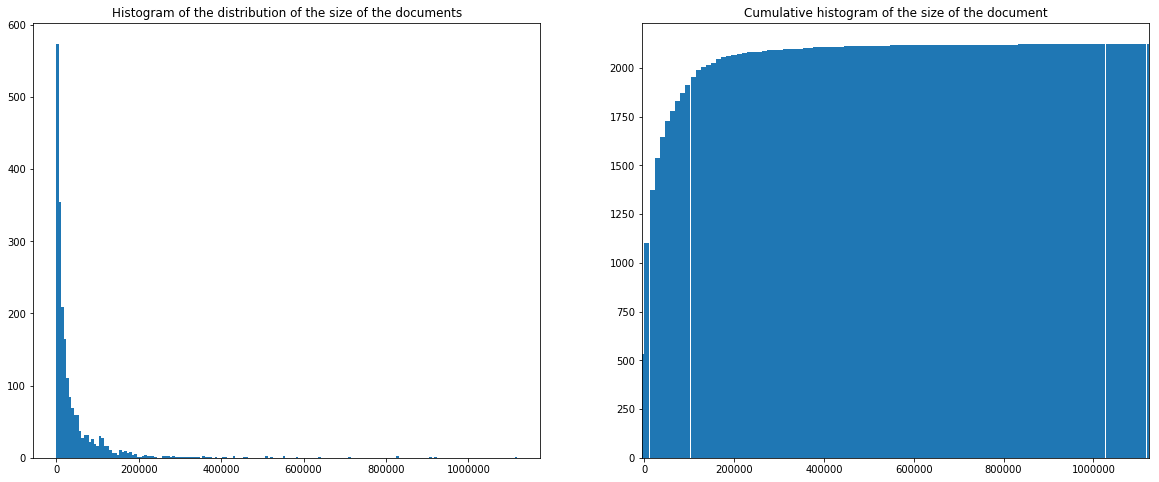

In [8]:
from scipy import stats
tab_len_train_data = [len(ele) for ele in train_data]

res = stats.cumfreq(tab_len_train_data, numbins=100)
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,res.cumcount.size)

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(tab_len_train_data, bins='auto')
ax1.set_title('Histogram of the distribution of the size of the documents')
ax2.bar(x, res.cumcount, width=res.binsize)
ax2.set_title('Cumulative histogram of the size of the document')
ax2.set_xlim([x.min(), x.max()])
plt.show()

## Analysis of the association word - label

Counting the number of apparition of each word for a given label

In [9]:
%%time
tab_of_word_stats = {}

tab_recap_length_train_sets = np.zeros(8)
tab_recap_num_train_sets = np.zeros(8)

n = len(y_train)
for i in range(n):
    indice = np.where(label_array == y_train[i])
    
    tab_recap_length_train_sets[indice]+=len(train_data[i])
    tab_recap_num_train_sets[indice]+=1
    
    for word in train_data[i].split():
        if type(tab_of_word_stats.get(word)) != type(None):
            tab_of_word_stats[word][indice]+=1    
        else:
            tab_val = np.zeros(8)
            tab_val[indice]+=1
            tab_of_word_stats[word] = tab_val
            
    if i % 500 == 0:
        print(str(i)+"/"+str(n), end="\r")

CPU times: user 1min 7s, sys: 149 ms, total: 1min 7s
Wall time: 1min 7s


Same as before but counting only one word a word per doc

In [10]:
%%time
tab_of_word_stats_per_doc = {}
n = len(y_train)
for i in range(n):
    indice = np.where(label_array == y_train[i])
    seen_words = []
    for word in train_data[i].split():
        if word not in seen_words:
            if type(tab_of_word_stats_per_doc.get(word)) != type(None):
                tab_of_word_stats_per_doc[word][indice]+=1    
            else:
                tab_val = np.zeros(8)
                tab_val[indice]+=1
                tab_of_word_stats_per_doc[word] = tab_val
        seen_words.append(word)
    if i % 500 == 0:
        print(str(i)+"/"+str(n), end="\r")

CPU times: user 9min 11s, sys: 314 ms, total: 9min 12s
Wall time: 9min 12s


## Plot the repartion of words per labels

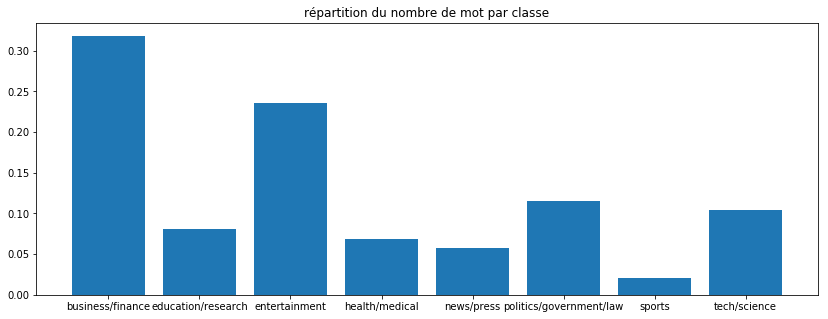

In [11]:
normalize_sized = tab_recap_length_train_sets/sum(tab_recap_length_train_sets)
plt.figure(figsize=(14,5))
plt.bar(label_array,normalize_sized)
plt.title("répartition du nombre de mot par classe")
plt.show()

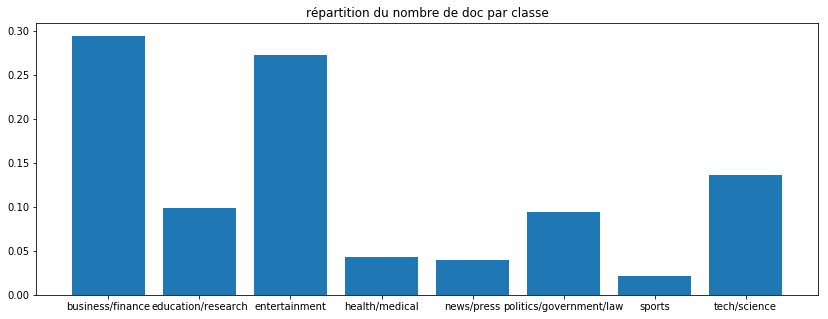

In [12]:
normalize_num = tab_recap_num_train_sets/sum(tab_recap_num_train_sets)
plt.figure(figsize=(14,5))
plt.bar(label_array,normalize_num)
plt.title("répartition du nombre de doc par classe")
plt.show()

## Evaluate the separability power of the words

In [13]:
def square_dist(tab_string,tab_normalized,label=label_array):
    tab_inv = [np.log(1/ele) for ele in tab_normalized]
    n = len(tab_string)
    mean = np.ones(n)*1/n
    average_tab = np.multiply(tab_string,tab_inv)
    percent_tab = average_tab/sum(average_tab)
    res = np.linalg.norm(percent_tab-mean)
    indice = np.argmax(percent_tab)
    return label[indice],indice,res

### test on some choosen words

One problem is to manage the word which apear almost never in the corpus

In [14]:
print('polepharma : ',tab_of_word_stats_per_doc['polepharma'])
print(square_dist(tab_of_word_stats_per_doc['polepharma'],normalize_sized))

print('cookie : ',tab_of_word_stats_per_doc['cookie'])
print(square_dist(tab_of_word_stats_per_doc['cookie'],normalize_sized))

print('offre : ',tab_of_word_stats_per_doc['offre'])
print(square_dist(tab_of_word_stats_per_doc['offre'],normalize_sized))

print('chiffre : ',tab_of_word_stats_per_doc['chiffre'])
print(square_dist(tab_of_word_stats_per_doc['chiffre'],normalize_sized))

print('embauche : ',tab_of_word_stats_per_doc['embauche'])
print(square_dist(tab_of_word_stats_per_doc['embauche'],normalize_sized))

print('cancer : ',tab_of_word_stats_per_doc['cancer'])
print(square_dist(tab_of_word_stats_per_doc['cancer'],normalize_sized))

polepharma :  [0. 0. 0. 1. 0. 0. 0. 0.]
('health/medical', 3, 0.9354143466934853)
cookie :  [72. 11. 38.  5.  8. 10.  4. 18.]
('business/finance', 0, 0.22381147543390628)
offre :  [243.  57. 131.  35.  31.  74.  12. 126.]
('tech/science', 7, 0.17929144080771456)
chiffre :  [46.  7. 16.  9. 14.  9.  1. 14.]
('business/finance', 0, 0.1852583769298943)
embauche :  [12.  4.  3.  2.  0. 10.  1.  5.]
('politics/government/law', 5, 0.25822560755261936)
cancer :  [16.  7. 22. 36.  8.  9.  2.  7.]
('health/medical', 3, 0.324217725522449)


### Find the most significant words for each class

### Delete the words which appear almost never

In [15]:
%%time
tab_clean_stats_per_doc = {}
min_apparition = 20

for ele in tab_of_word_stats_per_doc.keys():
    if(sum(tab_of_word_stats_per_doc[ele]) > min_apparition) :
        tab_clean_stats_per_doc[ele]=tab_of_word_stats_per_doc[ele]

CPU times: user 1.97 s, sys: 2.98 ms, total: 1.97 s
Wall time: 1.97 s


### Find the most important words regarding to our metrics

In [16]:
%%time
best_word_val = np.zeros((8,5))
best_word = [ ["" for x in range(5)] for x in range(8)]

for ele in tab_clean_stats_per_doc.keys():
    label, indice, seprability_power_actual = square_dist(tab_clean_stats_per_doc[ele],normalize_sized)
    i=0
    while(i<5):
        if(seprability_power_actual > best_word_val[indice][i]):
            for j in range(4,i-1,-1):
                best_word_val[indice][j] = best_word_val[indice][j-1]
                best_word[indice][j] = best_word[indice][j-1]
                
            best_word_val[indice][i] = seprability_power_actual
            best_word[indice][i] = ele
            i = 5
        else:
            i+=1

CPU times: user 989 ms, sys: 11 ms, total: 1 s
Wall time: 990 ms


In [17]:
df = pd.DataFrame(best_word, index=label_array, columns=['1', '2', '3', '4','5'])
df

,1,2,3,4,5
business/finance,repassage,bloctel,housse,vestes,détachées
education/research,inria,researchers,doctoral,anr,doctorales
entertainment,cupcakes,brunch,biscuit,saladier,macarons
health/medical,vasculaire,opératoire,cancérologie,dépistage,douleurs
news/press,trump,avalanche,commentés,commandant,gendarmes
politics/government/law,legifrance,relèvent,modernisation,pacs,recouvrement
sports,maillots,entraîneur,battu,wear,championnat
tech/science,geogebra,eula,soft32,utorrent,bittorrent


### Compute the percentage of words we still consider

In [18]:
print('the number of words in the train set is : ',len(tab_of_word_stats.keys()))
print('the number of words in the train set after cleaning is : ',len(tab_clean_stats_per_doc.keys()))
print('the percentage of remaining words is : ', len(tab_clean_stats_per_doc.keys())/len(tab_of_word_stats.keys()))

the number of words in the train set is :  321470
the number of words in the train set after cleaning is :  11966
the percentage of remaining words is :  0.03722275795564127


## Study of the Log-loss in 1D and 2D

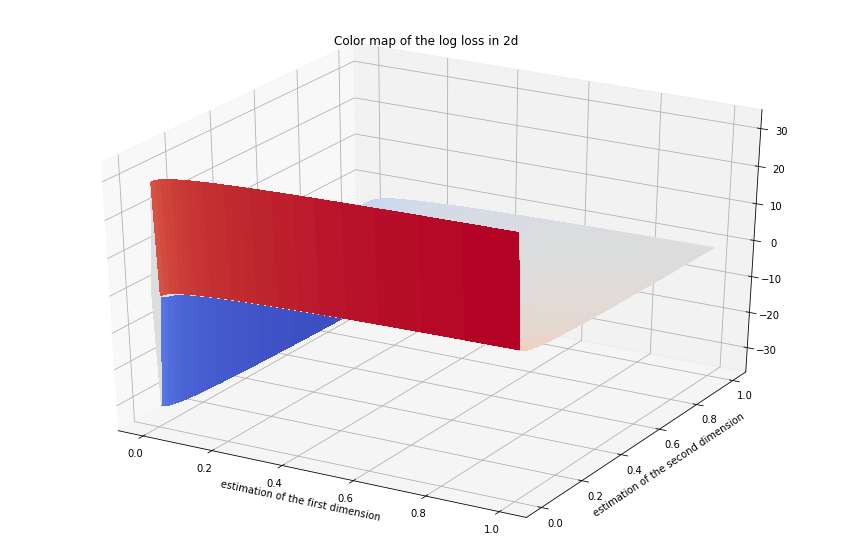

In [19]:
# Python-matplotlib Commands
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

def LogLossBinary(x,y, n=70,eps = 1e-15):
    result_mat = np.ones((n,n))
    actual = np.random.randint(0,1,n)
    
    actual_x = actual == 0
    actual_no_x = actual != 0
    actual_y = actual == 1
    actual_no_y = actual != 1
  
    predicted_x = np.minimum(np.maximum(x,eps*np.ones(n)),(1-eps)*np.ones(n))
    predicted_y = np.minimum(np.maximum(y,eps*np.ones(n)),(1-eps)*np.ones(n))
    
    log_loss_x = np.multiply(np.log(predicted_x),actual_x)
    log_loss_no_x = np.multiply(np.ones(n) - np.log(predicted_x),actual_no_x)
    
    log_loss_y = np.multiply(np.log(predicted_y),actual_y)
    log_loss_no_y = np.multiply(np.ones(n) - np.log(predicted_y),actual_no_y)

    for i in range(n):
        for j in range(n):
            result_mat[i,j] = - (log_loss_x[i]+log_loss_no_x[i]+log_loss_y[j]+log_loss_no_y[j])
    
    return result_mat

x = np.linspace(0,1,70) 
y = np.linspace(0,1,70)
z = np.linspace(0,1,70)


fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x, y)

Z = LogLossBinary(x,y, n=70,eps = 1e-15)

surf = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1,cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
plt.xlabel('estimation of the first dimension')
plt.ylabel('estimation of the second dimension')
plt.title("Color map of the log loss in 2d")

plt.show()

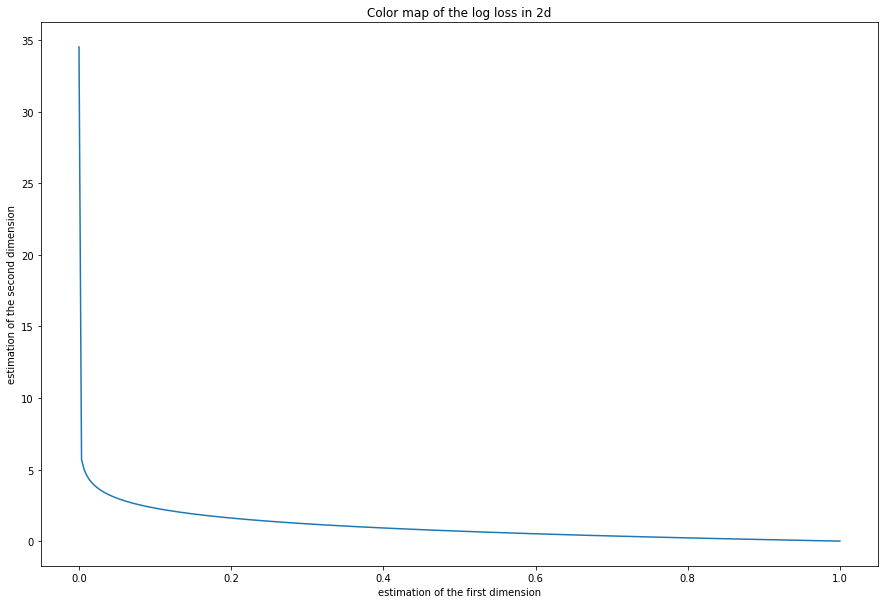

In [20]:
# Python-matplotlib Commands
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

def LogLossBinary1D(x, n=300,eps = 1e-15):
    result_mat = np.ones((n))*0
    actual = np.random.randint(0,1,n)
    
    actual_x = actual == 0
    actual_no_x = actual != 0
    
    predicted_x = np.minimum(np.maximum(x,eps*np.ones(n)),(1-eps)*np.ones(n))

    log_loss_x = np.multiply(np.log(predicted_x),actual_x)
    log_loss_no_x = np.multiply(np.ones(n) - np.log(predicted_x),actual_no_x)
    
    for i in range(n):
         result_mat[i] = - (log_loss_x[i]+log_loss_no_x[i])
    
    return result_mat
x = np.linspace(0,1,300) 
Z = LogLossBinary1D(x, n=300,eps = 1e-15)


plt.xlabel('estimation of the first dimension')
plt.ylabel('estimation of the second dimension')
plt.title("Color map of the log loss in 2d")
plt.plot(x,Z)

plt.show()

# Graph Analysis

## Initilisation

### Creation of the graph and the sub graph of the train set.

In [21]:
G = nx.read_weighted_edgelist(path_data+'edgelist.txt', create_using=nx.DiGraph())
G_train = G.subgraph(train_hosts)
print('the total number of nodes in the graph is : ',G.number_of_nodes())
print('the total number of edges in the graph is : ',G.number_of_edges())
print('the number of nodes in the subgraph of the train set is : ',G_train.number_of_nodes())
print('the number of edges in the subgraph of the train set is : ',G_train.number_of_edges())

the total number of nodes in the graph is :  28002
the total number of edges in the graph is :  319498
the number of nodes in the subgraph of the train set is :  1994
the number of edges in the subgraph of the train set is :  5067


## Study of the neighbors label matrices

### Creation of the matrices of the number of edges from one labels to another

In [22]:
matrix_labels = np.zeros((8,8))
matrix_labels_weighted = np.zeros((8,8))
for i in range(len(y_train)):
    # get the label of the current element
    indice_label_actuel = int(np.where(label_array == y_train[i])[0])
    # get the neighbors of the node
    number_actual = train_hosts[i]
    tab_neighbors = list(nx.neighbors(G_train,number_actual))
    #loop on the neighbors
    for ele in tab_neighbors:
        #print(ele)
        # find the indices of the neighbor
        number_neighbor = np.where(np.array(train_hosts) == str(ele))
        #print(number_neighbor)
        number_neighbor = int(number_neighbor[0][0])
        indice_class_neigbors = int(np.where(label_array == y_train[number_neighbor])[0])
        matrix_labels[indice_label_actuel][indice_class_neigbors] += 1
        matrix_labels_weighted[indice_label_actuel][indice_class_neigbors] += G_train[number_actual][ele]['weight']

## Plot the weighted and unweighted matrices.

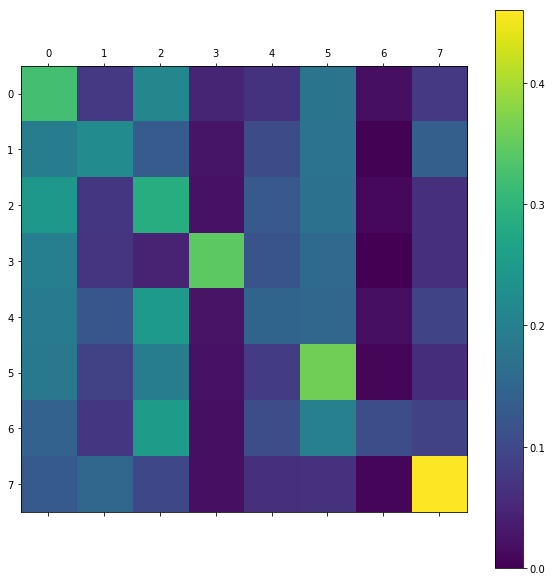

In [23]:
from sklearn.preprocessing import normalize

normed_matrix = normalize(matrix_labels, axis=1, norm='l1')
plt.matshow(normed_matrix);
plt.colorbar()
plt.show()

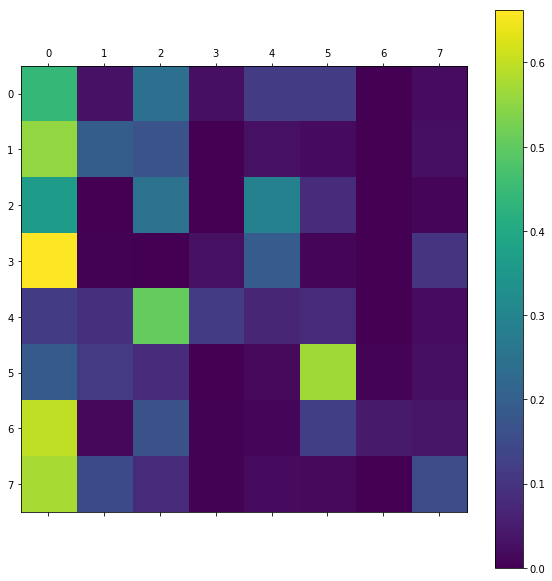

In [24]:
normed_matrix_weighted = normalize(matrix_labels_weighted, axis=1, norm='l1')
plt.matshow(normed_matrix_weighted);
plt.colorbar()
plt.show()

### Creation of the matrices of the number of edges from one labels to another weighted by the number of neighbor of the nodes

In [25]:
matrix_labels_norm = np.zeros((8,8))
matrix_labels_weighted_norm = np.zeros((8,8))

for i in range(len(y_train)):
    # get the label of the current element
    indice_label_actuel = int(np.where(label_array == y_train[i])[0])
    # get the neighbors of the node
    number_actual = train_hosts[i]
    tab_neighbors = list(nx.neighbors(G_train,number_actual))
    
    num_neighbors = len(tab_neighbors)
    
    # loop to get the total of the weight 
    total_weight = 0
    for ele in tab_neighbors: 
        total_weight += G_train[number_actual][ele]['weight']
    
    #loop on the neighbors
    for ele in tab_neighbors:
        #print(ele)
        # find the indices of the neighbor
        number_neighbor = np.where(np.array(train_hosts) == str(ele))
        #print(number_neighbor)
        number_neighbor = int(number_neighbor[0][0])

        indice_class_neigbors = int(np.where(label_array == y_train[number_neighbor])[0])
        matrix_labels_norm[indice_label_actuel][indice_class_neigbors] += 1/num_neighbors
        matrix_labels_weighted_norm[indice_label_actuel][indice_class_neigbors] += G_train[number_actual][ele]['weight']/total_weight

### Plot of the weighted and unweighted matrices.

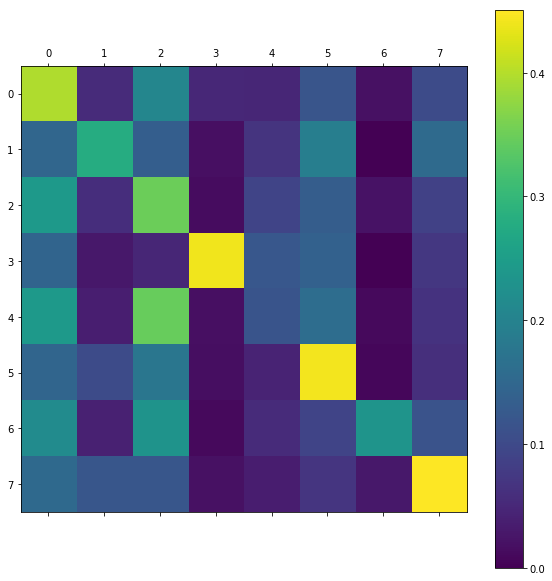

In [26]:
from sklearn.preprocessing import normalize

normed_matrix_norm = normalize(matrix_labels_norm, axis=1, norm='l1')
plt.matshow(normed_matrix_norm);
plt.colorbar()
plt.show()

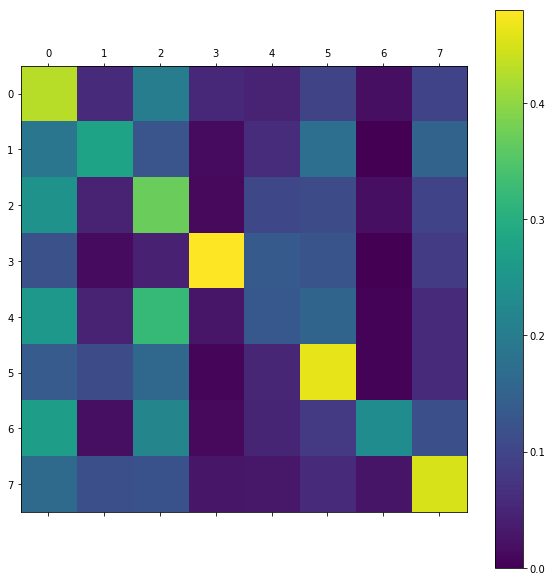

In [27]:
normed_matrix_weighted_norm = normalize(matrix_labels_weighted_norm, axis=1, norm='l1')
plt.matshow(normed_matrix_weighted_norm);
plt.colorbar()
plt.show()